## PROYECTO SPRING 9

### JAVIER CRUZ

#### Descripción del proyecto

Lo has hecho de maravilla en el curso de TripleTen y te han ofrecido hacer prácticas en el departamento de analítica de Showz, una empresa de venta de entradas de eventos. Tu primera tarea es ayudar a optimizar los gastos de marketing. 

Cuentas con:

- registros del servidor con datos sobre las visitas a Showz desde enero de 2017 hasta diciembre de 2018;
- un archivo con los pedidos en este periodo;
- estadísticas de gastos de marketing.
Lo que vas a investigar: 

- cómo los clientes usan el servicio;
- cuándo empiezan a comprar;
- cuánto dinero aporta cada cliente a la compañía;
- cuándo los ingresos cubren el costo de adquisición de los clientes.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [32]:
# Configuración de visualización
plt.style.use('seaborn')
pd.set_option('display.max_columns', None)

# Cargar los datasets
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')

In [33]:
# Convertir columnas de fecha a datetime
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [34]:
# Verificar valores nulos
print("Valores nulos en visits:")
print(visits.isnull().sum())
print("\nValores nulos en orders:")
print(orders.isnull().sum())
print("\nValores nulos en costs:")
print(costs.isnull().sum())

Valores nulos en visits:
Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

Valores nulos en orders:
Buy Ts     0
Revenue    0
Uid        0
dtype: int64

Valores nulos en costs:
source_id    0
dt           0
costs        0
dtype: int64


In [35]:
# Análisis diario
daily_visits = visits.groupby(visits['Start Ts'].dt.date)['Uid'].nunique()
daily_sessions = visits.groupby(visits['Start Ts'].dt.date).size()

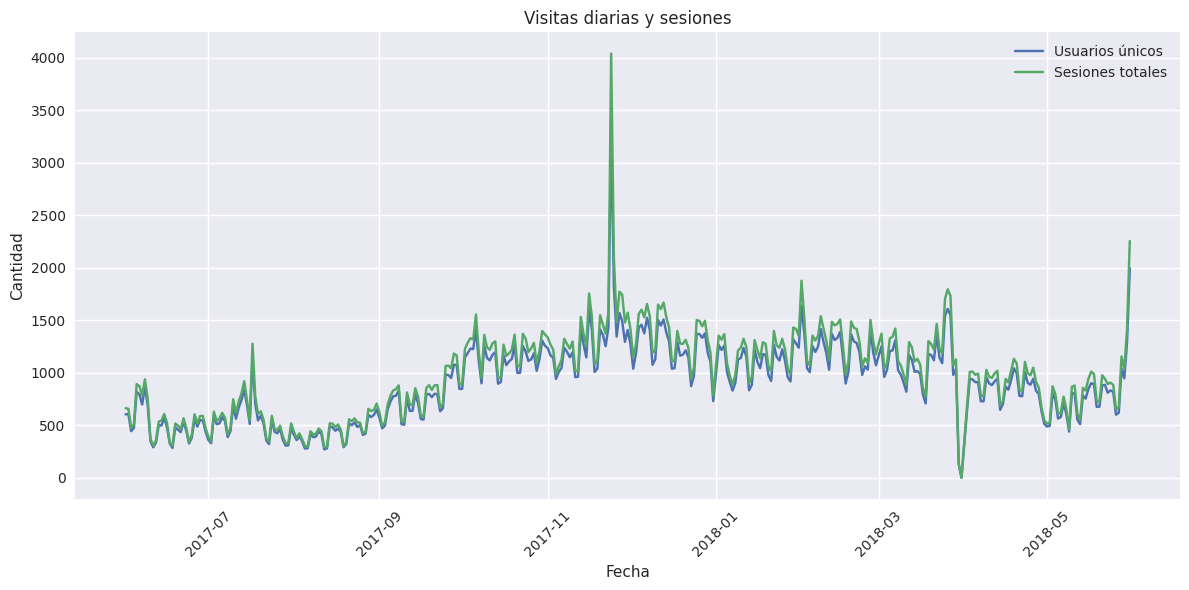

In [47]:
# Grafica
plt.figure(figsize=(12, 6))
plt.plot(daily_visits.index, daily_visits.values, label='Usuarios únicos')
plt.plot(daily_sessions.index, daily_sessions.values, label='Sesiones totales')
plt.title('Visitas diarias y sesiones')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Análisis de duración de sesiones

In [37]:
# Calcular duración de sesiones en minutos
visits['session_duration'] = (visits['End Ts'] - visits['Start Ts']).dt.total_seconds() / 60

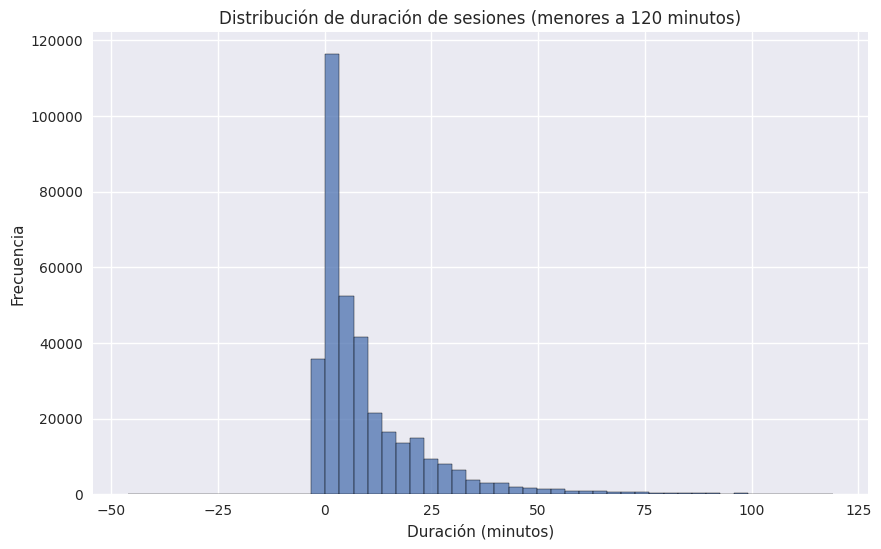

In [48]:
# graficar distribución de duración de sesiones
plt.figure(figsize=(10, 6))
sns.histplot(data=visits[visits['session_duration'] < 120], x='session_duration', bins=50)
plt.title('Distribución de duración de sesiones (menores a 120 minutos)')
plt.xlabel('Duración (minutos)')
plt.ylabel('Frecuencia')
plt.show()

### Análisis de conversión y tiempo hasta la primera compra

In [39]:
# Unir visits y orders para análisis de conversión
first_orders = orders.groupby('Uid')['Buy Ts'].min().reset_index()
first_visits = visits.groupby('Uid')['Start Ts'].min().reset_index()

conversion_data = pd.merge(first_visits, first_orders, on='Uid', how='left')
conversion_data['days_to_conversion'] = (conversion_data['Buy Ts'] - conversion_data['Start Ts']).dt.days

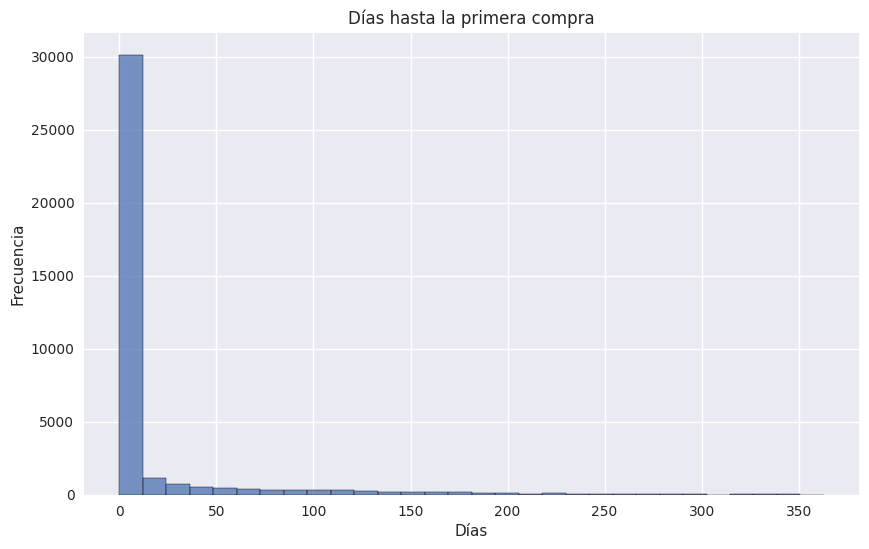

In [49]:
# graficar distribución de días hasta la conversión
plt.figure(figsize=(10, 6))
sns.histplot(data=conversion_data[conversion_data['days_to_conversion'] >= 0],
             x='days_to_conversion', bins=30)
plt.title('Días hasta la primera compra')
plt.xlabel('Días')
plt.ylabel('Frecuencia')
plt.show()

### Análisis de ingresos y LTV

In [41]:
# Calcular LTV por usuario
user_ltv = orders.groupby('Uid')['Revenue'].sum()

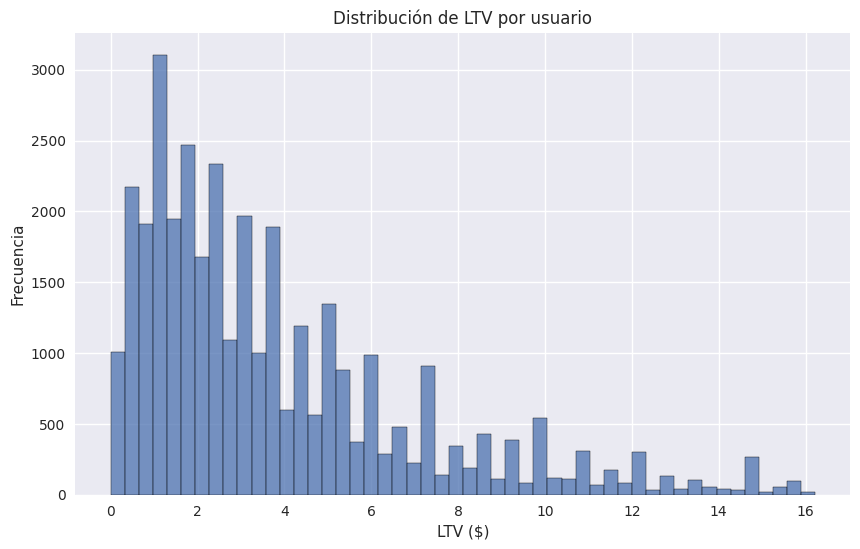

In [50]:
# Graficar distribución de LTV
plt.figure(figsize=(10, 6))
sns.histplot(data=user_ltv[user_ltv < user_ltv.quantile(0.95)], bins=50)
plt.title('Distribución de LTV por usuario')
plt.xlabel('LTV ($)')
plt.ylabel('Frecuencia')
plt.show()

### Análisis de gastos de marketing y ROI

In [43]:
# Calcular gastos totales por fuente
marketing_costs = costs.groupby('source_id')['costs'].sum()

In [44]:
# Calcular ingresos por fuente
user_source = visits[['Uid', 'Source Id']].drop_duplicates()
revenue_by_source = pd.merge(user_source, orders, on='Uid')
revenue_by_source = revenue_by_source.groupby('Source Id')['Revenue'].sum()

In [45]:
# Calcular ROI
roi_by_source = (revenue_by_source - marketing_costs) / marketing_costs * 100

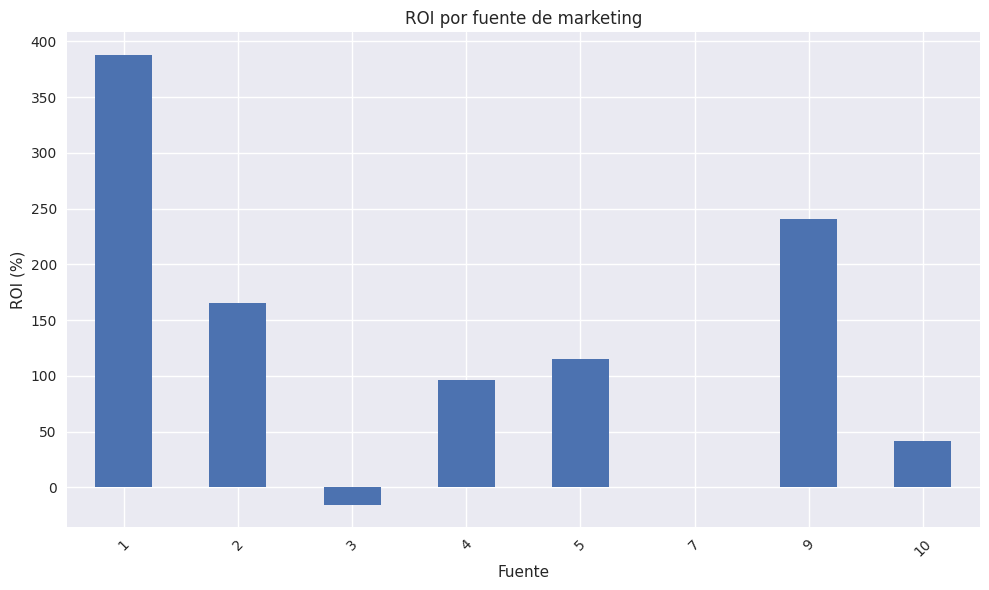

In [51]:
# Graficar ROI por fuente
plt.figure(figsize=(10, 6))
roi_by_source.plot(kind='bar')
plt.title('ROI por fuente de marketing')
plt.xlabel('Fuente')
plt.ylabel('ROI (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Hipótesis:

Es posible que las campañas de marketing que requieren una inversión inicial más grande terminen dando mejores resultados a largo plazo. Esto podría deberse a que atraen a usuarios de mayor calidad, que tienen más probabilidades de convertirse en clientes.

Conclusión:

Después de revisar los datos, parece sensato enfocar la inversión en las fuentes de marketing que demuestran un buen retorno de la inversión (ROI) y que convierten a los usuarios en clientes rápidamente. Es importante dar prioridad a aquellas plataformas donde los usuarios tienden a gastar más a lo largo del tiempo (LTV) y se quedan por más tiempo. De esta manera, se puede aprovechar al máximo el presupuesto de marketing y aumentar las ganancias de Showz.